# Install Dependency

In [ ]:
!pip install ultralytics

In [ ]:
!pip install supervision

# Import Library

In [ ]:
from IPython.display import HTML, display
from base64 import b64encode
import os
import numpy as np
import cv2
import subprocess
import shlex
from collections import defaultdict, deque

import supervision as sv
from ultralytics import YOLO
from google.colab.patches import cv2_imshow

# Utils

Fungsi utilitas untuk menampilkan file video MP4 langsung di dalam sel notebook.

In [ ]:
def display_mp4(
    video_path: str,
    width: int = 720,
    autoplay: bool = False,
    loop: bool = False,
    controls: bool = True,
):
    # INPUT VALIDATION
    if not os.path.exists(video_path):
        raise FileNotFoundError(f"Video not found: {video_path}")

    # LOAD VIDEO (BINARY)
    mp4 = open(video_path, "rb").read()

    # ENCODE → DATA URL
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()

    # HTML VIDEO EMBED
    html = f"""
    <video width="{width}"
           {'autoplay' if autoplay else ''}
           {'loop' if loop else ''}
           {'controls' if controls else ''}>
      <source src="{data_url}" type="video/mp4">
    </video>
    """

    # RENDER (NOTEBOOK)
    display(HTML(html))


Fungsi utilitas untuk menulis frame video mentah (raw frame) menjadi file MP4 menggunakan FFmpeg. Bisa menggunakan OpenCV namun supaya langsung streamable digunakan ffmpeg

In [ ]:
def start_ffmpeg_writer(
    output_path,
    width,
    height,
    fps=25
):
    # FFmpeg COMMAND
    cmd = f"""
    ffmpeg -y
    -f rawvideo
    -pix_fmt bgr24
    -s {width}x{height}
    -r {fps}
    -i -
    -an
    -c:v libx264
    -preset veryfast
    -pix_fmt yuv420p
    -movflags faststart
    {output_path}
    """

    # PROCESS PIPE (STDIN)
    return subprocess.Popen(
        shlex.split(cmd),
        stdin=subprocess.PIPE,
        stdout=subprocess.DEVNULL,
        stderr=subprocess.DEVNULL,
    )


# Download Source

Download source video dari drive

In [ ]:
!gdown 1_9gMqPhNKOnbHUoSQvoWhvd8pUnxUOFB

# Display Raw Video

Menampilkan source video

In [ ]:
raw_video_path = "traffic.mp4"
display_mp4(video_path=raw_video_path)

## Info Data

Menampilkan informasi dasar video serta pratinjau frame pertama untuk validasi data awal.

In [ ]:
# VIDEO METADATA
cap = cv2.VideoCapture(raw_video_path)

width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps    = cap.get(cv2.CAP_PROP_FPS) or 25

# FIRST FRAME (VALIDATION)
cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
ret, first_frame = cap.read()
if not ret:
    raise RuntimeError("Gagal membaca frame pertama")

cap.release()

# INFO OUTPUT
print(f"Width: {width}")
print(f"Height: {height}")
print(f"FPS: {fps}")

print("First Frame")
cv2_imshow(first_frame)

Opsi lain bisa menggunakan supervision untuk mendapatkan video info

In [ ]:
video_info = sv.VideoInfo.from_video_path(video_path=raw_video_path)
video_info

# Object Detection

## Load Model

Memuat model deteksi dan melakukan warm-up awal agar inferensi berjalan lebih stabil.

In [ ]:
# LOAD MODEL
weights = "yolo11n.pt"
model = YOLO(weights)

In [ ]:
# WARM UP
warmup_runs = 5
dummy = np.zeros((640, 640, 3), dtype=np.uint8)
for _ in range(warmup_runs):
    _ = model.predict(dummy)

## Prepare

Melakukan uji deteksi objek pada satu frame untuk memvalidasi kelas, confidence, dan hasil anotasi awal.

In [ ]:
# FRAME PREP
annotate = first_frame.copy()

# ANNOTATORS
box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

# DETECTION (SINGLE FRAME)
results = model.predict(
    annotate,
    conf=0.25,
    classes=[2, 5, 7],
    verbose=False
)

detections = sv.Detections.from_ultralytics(results[0])

# LABEL FORMAT
labels = [
    f"{class_name} {conf:.2f}"
    for class_name, conf in zip(
        detections.data["class_name"],
        detections.confidence
    )
]

# VISUALIZATION
annotated = box_annotator.annotate(annotate, detections)
annotated = label_annotator.annotate(annotated, detections, labels)

# DEBUG OUTPUT
print(f"result yolo: {results[0].boxes}\n")
print(f"dets: {detections}")

cv2_imshow(annotated)


## Pipeline

Pipeline utama untuk menjalankan tugas object detection pada video.

In [ ]:
# VIDEO INPUT
cap = cv2.VideoCapture(raw_video_path)

width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps    = cap.get(cv2.CAP_PROP_FPS) or 25

# VIDEO OUTPUT
ffmpeg = start_ffmpeg_writer(
    output_path="object_detection.mp4",
    width=width,
    height=height,
    fps=fps
)

# ANNOTATORS
box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

# MAIN LOOP
while True:
    ret, frame = cap.read()
    if not ret:
        break

    # DETECTION
    results = model.predict(
        frame,
        conf=0.25,
        classes=[2, 5, 7],
        verbose=False
    )
    detections = sv.Detections.from_ultralytics(results[0])

    # LABEL FORMAT
    labels = [
        f"{class_name} {conf:.2f}"
        for class_name, conf in zip(
            detections.data["class_name"],
            detections.confidence
        )
    ]

    # VISUALIZATION
    annotated = box_annotator.annotate(frame, detections)
    annotated = label_annotator.annotate(annotated, detections, labels)

    # WRITE FRAME
    ffmpeg.stdin.write(annotated.tobytes())

# CLEANUP
cap.release()
ffmpeg.stdin.close()
ffmpeg.wait()


Menampilkan hasil video dengan object detection

In [ ]:
od_video_path = "object_detection.mp4"
display_mp4(video_path=od_video_path)

# Tracking Object

## Prepare

Menyiapkan dan memvalidasi mekanisme object tracking pada satu frame sebelum diterapkan ke pipeline penuh.

In [ ]:
# FRAME PREP
annotate = first_frame.copy()

# TRACKER
tracker = sv.ByteTrack()

# ANNOTATORS
box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

# DETECTION + TRACKING (SINGLE FRAME)
results = model.predict(
    annotate,
    conf=0.25,
    classes=[2, 5, 7],
    verbose=False
)

detections = sv.Detections.from_ultralytics(results[0])
detections = tracker.update_with_detections(detections)

# LABEL FORMAT (TRACK ID)
labels = []
for class_name, conf, tid in zip(
    detections.data["class_name"],
    detections.confidence,
    detections.tracker_id
):
    labels.append(f"#{tid} | {class_name} {conf:.2f}")

# VISUALIZATION
annotated = box_annotator.annotate(annotate, detections)
annotated = label_annotator.annotate(annotated, detections, labels)

# DEBUG OUTPUT
print(f"dets: {detections}")

cv2_imshow(annotated)


## Pipeline

Pipeline utama untuk menjalankan object tracking dengan memperbarui identitas objek berdasarkan hasil deteksi pada setiap frame.

In [ ]:
# VIDEO INPUT
cap = cv2.VideoCapture(raw_video_path)

width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps    = cap.get(cv2.CAP_PROP_FPS) or 25

# VIDEO OUTPUT
ffmpeg = start_ffmpeg_writer(
    output_path="tracking_object.mp4",
    width=width,
    height=height,
    fps=fps
)

# TRACKER
tracker = sv.ByteTrack()

# ANNOTATORS
box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

# MAIN LOOP
while True:
    ret, frame = cap.read()
    if not ret:
        break

    # OBJECT DETECTION
    results = model.predict(
        frame,
        conf=0.25,
        classes=[2, 5, 7],
        verbose=False
    )
    detections = sv.Detections.from_ultralytics(results[0])

    # TRACK UPDATE (POST-DETECTION)
    detections = tracker.update_with_detections(detections)

    # LABEL FORMAT (TRACK ID)
    labels = []
    for class_name, conf, tid in zip(
        detections.data["class_name"],
        detections.confidence,
        detections.tracker_id
    ):
        labels.append(f"ID {tid} | {class_name} {conf:.2f}")

    # VISUALIZATION
    annotated = box_annotator.annotate(frame, detections)
    annotated = label_annotator.annotate(annotated, detections, labels)

    # WRITE FRAME
    ffmpeg.stdin.write(annotated.tobytes())

# CLEANUP
cap.release()
ffmpeg.stdin.close()
ffmpeg.wait()

Menampilkan video hasil penererapan tracking object

In [ ]:
to_video_path = "tracking_object.mp4"
display_mp4(video_path=to_video_path)

# Geofencing

## Define Zone

Mendefinisikan area zona masuk dan keluar pada frame awal sebagai dasar proses geofencing.

In [ ]:
# ZONE COORDINATES
in_point = np.array([
    [294, 394],
    [596, 394],
    [577, 486],
    [114, 486]
])

out_point = np.array([
    [684, 394],
    [988, 394],
    [1160, 486],
    [702, 486]
])

In [ ]:
# FRAME PREP
annotate = first_frame.copy()

# IN ZONE
in_zone = sv.PolygonZone(
    polygon=in_point,
    triggering_anchors=(sv.Position.BOTTOM_LEFT,)
)
in_zone_annotator = sv.PolygonZoneAnnotator(
    zone=in_zone,
    color=sv.Color.GREEN,
    thickness=2,
    text_thickness=1,
    text_scale=0.7,
    opacity=0.3
)

# OUT ZONE
out_zone = sv.PolygonZone(
    polygon=out_point,
    triggering_anchors=(sv.Position.TOP_RIGHT,)
)
out_zone_annotator = sv.PolygonZoneAnnotator(
    zone=out_zone,
    color=sv.Color.RED,
    thickness=2,
    text_thickness=1,
    text_scale=0.7,
    opacity=0.3
)

# VISUAL VALIDATION
annotate = in_zone_annotator.annotate(scene=annotate, label="IN")
annotate = out_zone_annotator.annotate(scene=annotate, label="OUT")

cv2_imshow(annotate)

## Pipeline

Pipeline utama untuk menjalankan geofencing dengan mendeteksi, melacak, dan mengevaluasi pergerakan objek terhadap zona yang telah ditentukan.

In [ ]:
# VIDEO INPUT
cap = cv2.VideoCapture(raw_video_path)

width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps    = cap.get(cv2.CAP_PROP_FPS) or 25

# VIDEO OUTPUT
ffmpeg = start_ffmpeg_writer(
    output_path="geofencing.mp4",
    width=width,
    height=height,
    fps=fps
)

# TRACKER
tracker = sv.ByteTrack()

# ANNOTATORS
box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

# ZONES
in_zone = sv.PolygonZone(
    polygon=in_point,
    triggering_anchors=(sv.Position.BOTTOM_LEFT,)
)
in_zone_annotator = sv.PolygonZoneAnnotator(
    zone=in_zone,
    color=sv.Color.GREEN,
    thickness=2,
    text_thickness=1,
    text_scale=0.7,
    opacity=0.3
)

out_zone = sv.PolygonZone(
    polygon=out_point,
    triggering_anchors=(sv.Position.TOP_RIGHT,)
)
out_zone_annotator = sv.PolygonZoneAnnotator(
    zone=out_zone,
    color=sv.Color.RED,
    thickness=2,
    text_thickness=1,
    text_scale=0.7,
    opacity=0.3
)

# MAIN LOOP
while True:
    ret, frame = cap.read()
    if not ret:
        break

    # OBJECT DETECTION
    results = model.predict(
        frame,
        conf=0.25,
        classes=[2, 5, 7],
        verbose=False
    )
    detections = sv.Detections.from_ultralytics(results[0])

    # TRACK UPDATE (POST-DETECTION)
    detections = tracker.update_with_detections(detections)

    # LABEL FORMAT (TRACK ID + CLASS NAME)
    labels = []
    for class_name, conf, tid in zip(
        detections.data["class_name"],
        detections.confidence,
        detections.tracker_id
    ):
        labels.append(f"ID {tid} | {class_name} {conf:.2f}")

    # ZONE VISUALIZATION
    annotated = in_zone_annotator.annotate(scene=frame, label="IN")
    annotated = out_zone_annotator.annotate(scene=annotated, label="OUT")

    # OBJECT VISUALIZATION
    annotated = box_annotator.annotate(annotated, detections)
    annotated = label_annotator.annotate(annotated, detections, labels)

    # WRITE FRAME
    ffmpeg.stdin.write(annotated.tobytes())

# CLEANUP
cap.release()
ffmpeg.stdin.close()
ffmpeg.wait()

Menampilkan hasil video dari proses geofencing

In [ ]:
geo_video_path = "geofencing.mp4"
display_mp4(video_path=geo_video_path)

# Object Counting

## Prepare

### Get Insight

Menyiapkan struktur data dan memvalidasi logika penghitungan objek berdasarkan zona dan kelas pada satu frame awal.

In [ ]:
# COUNT STATE
vehicle_counts = {
    "in": {
        "all": set(),
        "car": set(),
        "bus": set(),
        "truck": set()
    },
    "out": {
        "all": set(),
        "car": set(),
        "bus": set(),
        "truck": set()
    }
}

In [ ]:
# TRACKER
tracker = sv.ByteTrack()

# DETECTION + TRACKING (SINGLE FRAME)
results = model.predict(
    first_frame,
    conf=0.25,
    classes=[2, 5, 7],
    verbose=False
)
detections = sv.Detections.from_ultralytics(results[0])
detections = tracker.update_with_detections(detections)

# ZONE TRIGGER
in_mask = in_zone.trigger(detections)
out_mask = out_zone.trigger(detections)

in_dets = detections[in_mask]
out_dets = detections[out_mask]

# DEBUG INSPECTION
print(f"raw_dets: {detections}\n")
print(f"in_mask: {in_mask}\n")
print(f"in_dets: {in_dets}\n")

In [ ]:
# COUNT (IN ZONE)
for class_name, tid in zip(
    in_dets.data["class_name"],
    in_dets.tracker_id
):
    vehicle_counts["in"]["all"].add(tid)
    vehicle_counts["in"][class_name].add(tid)

vehicle_counts

In [ ]:
def collect_insight(vehicle_counts, detections, zone):
    # GUARD
    if detections.tracker_id is None:
        return

    # UPDATE COUNT STATE
    for class_name, tid in zip(
        detections.data["class_name"],
        detections.tracker_id
    ):
        vehicle_counts[zone]["all"].add(tid)
        vehicle_counts[zone][class_name].add(tid)


# APPLY (SINGLE FRAME)
collect_insight(vehicle_counts, in_dets, "in")
collect_insight(vehicle_counts, out_dets, "out")

vehicle_counts


### Show the Insight

Menampilkan panel visual untuk memverifikasi hasil penghitungan objek per zona dan kategori.

In [ ]:
# FRAME PREP
text_annotate = annotate.copy()

# HEADER: CATEGORY
WIDTH_CAT = 100
HEIGHT_CAT = 30
X_CAT = width // 2 - WIDTH_CAT / 2
Y_CAT = 10

CENTER_X_CAT = X_CAT + WIDTH_CAT // 2
CENTER_Y_CAT = Y_CAT + HEIGHT_CAT // 2

rect = sv.Rect(X_CAT, Y_CAT, WIDTH_CAT, HEIGHT_CAT)

scene = sv.draw_filled_rectangle(
    scene=text_annotate,
    rect=rect,
    color=sv.Color.BLUE,
    opacity=0.5,
)

text_annotate = sv.draw_text(
    scene=text_annotate,
    text="CATEGORY",
    text_anchor=sv.Point(CENTER_X_CAT, CENTER_Y_CAT),
    text_color=sv.Color.WHITE,
    text_scale=0.5,
    text_thickness=1,
)

# HEADER: IN
WIDTH_IN = 60
HEIGHT_IN = 30
GAP = 10

X_IN = X_CAT - WIDTH_IN - GAP
Y_IN = 10

center_x_in = X_IN + WIDTH_IN // 2
center_y_in = Y_IN + HEIGHT_IN // 2

rect = sv.Rect(X_IN, Y_IN, WIDTH_IN, HEIGHT_IN)

scene = sv.draw_filled_rectangle(
    scene=text_annotate,
    rect=rect,
    color=sv.Color.GREEN,
    opacity=0.5,
)

text_annotate = sv.draw_text(
    scene=text_annotate,
    text="IN",
    text_anchor=sv.Point(center_x_in, center_y_in),
    text_color=sv.Color.WHITE,
    text_scale=0.5,
    text_thickness=1,
)

# HEADER: OUT
WIDTH_OUT = 60
HEIGHT_OUT = 30
X_OUT = X_CAT + WIDTH_CAT + GAP
Y_OUT = Y_CAT

center_x_out = X_OUT + WIDTH_OUT // 2
center_y_out = Y_OUT + HEIGHT_OUT // 2

rect = sv.Rect(X_OUT, Y_OUT, WIDTH_OUT, HEIGHT_OUT)

text_annotate = sv.draw_filled_rectangle(
    scene=text_annotate,
    rect=rect,
    color=sv.Color.RED,
    opacity=0.5,
)

text_annotate = sv.draw_text(
    scene=text_annotate,
    text="OUT",
    text_anchor=sv.Point(center_x_out, center_y_out),
    text_color=sv.Color.WHITE,
    text_scale=0.5,
    text_thickness=1,
)

cv2_imshow(text_annotate)


Fungsi utilitas untuk menggambar panel ringkasan jumlah kendaraan per zona dan kategori.

In [ ]:
def draw_cell(scene, x, y, width, height, text, color, opacity=0.5, text_scale: float = 0.5, text_thickness: int = 1):
    rect = sv.Rect(x, y, width, height)
    scene = sv.draw_filled_rectangle(
        scene=scene,
        rect=rect,
        color=color,
        opacity=opacity,
    )
    scene = sv.draw_text(
        scene=scene,
        text=text,
        text_anchor=sv.Point(
            x + width // 2,
            y + height // 2,
        ),
        text_color=sv.Color.WHITE,
        text_scale=text_scale,
        text_thickness=text_thickness,
    )

def draw_insight(
    scene: np.ndarray,
    vehicle_counts: dict,
    *,
    start_y: int = 10,
    gap_x: int = 10,
    gap_y: int = 6,
    width_in: int = 60,
    width_cat: int = 100,
    width_out: int = 60,
    height_row: int = 30,
    opacity: float = 0.5,
    text_scale: float = 0.5,
    text_thickness: int = 1,
) -> np.ndarray:

    h, w, _ = scene.shape

    # layout positions
    total_width = width_in + width_cat + width_out + gap_x * 2
    x_cat = w // 2 - width_cat // 2
    x_in = x_cat - width_in - gap_x
    x_out = x_cat + width_cat + gap_x

    # helper

    def get_count(direction, key):
        return len(vehicle_counts.get(direction, {}).get(key, set()))

    # header
    y = start_y

    draw_cell(scene, x_in, y, width_in, height_row, "IN", sv.Color.GREEN)
    draw_cell(scene, x_cat, y, width_cat, height_row, "CATEGORY", sv.Color.BLUE)
    draw_cell(scene, x_out, y, width_out, height_row, "OUT", sv.Color.RED)

    # rows (NO motorcycle)
    rows = ["all", "car", "bus", "truck"]

    for i, key in enumerate(rows, start=1):
        row_y = start_y + i * (height_row + gap_y)

        draw_cell(
            scene,
            x_in,
            row_y,
            width_in,
            height_row,
            f"{get_count('in', key):04d}",
            sv.Color.GREEN,
        )

        draw_cell(
            scene,
            x_cat,
            row_y,
            width_cat,
            height_row,
            key.upper(),
            sv.Color.BLUE,
        )

        draw_cell(
            scene,
            x_out,
            row_y,
            width_out,
            height_row,
            f"{get_count('out', key):04d}",
            sv.Color.RED,
        )

    return scene


In [ ]:
# FINAL VISUAL CHECK
text_annotate = annotate.copy()
text_annotate = draw_insight(text_annotate, vehicle_counts)

cv2_imshow(text_annotate)

## Pipeline

Pipeline utama untuk menghitung jumlah objek berdasarkan zona masuk dan keluar, serta menampilkan ringkasan insight secara real-time pada video.

In [ ]:
# VIDEO INPUT
cap = cv2.VideoCapture(raw_video_path)

width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps    = cap.get(cv2.CAP_PROP_FPS) or 25

# VIDEO OUTPUT
ffmpeg = start_ffmpeg_writer(
    output_path="insight.mp4",
    width=width,
    height=height,
    fps=fps
)

# TRACKER
tracker = sv.ByteTrack()

# ANNOTATORS
box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

# ZONES
in_zone = sv.PolygonZone(
    polygon=in_point,
    triggering_anchors=(sv.Position.BOTTOM_LEFT,)
)
in_zone_annotator = sv.PolygonZoneAnnotator(
    zone=in_zone,
    color=sv.Color.GREEN,
    thickness=2,
    text_thickness=1,
    text_scale=0.7,
    opacity=0.3
)

out_zone = sv.PolygonZone(
    polygon=out_point,
    triggering_anchors=(sv.Position.TOP_RIGHT,)
)
out_zone_annotator = sv.PolygonZoneAnnotator(
    zone=out_zone,
    color=sv.Color.RED,
    thickness=2,
    text_thickness=1,
    text_scale=0.7,
    opacity=0.3
)

# COUNT STATE
vehicle_counts = {
    "in":  {"all": set(), "car": set(), "bus": set(), "truck": set()},
    "out": {"all": set(), "car": set(), "bus": set(), "truck": set()},
}

# MAIN LOOP
while True:
    ret, frame = cap.read()
    if not ret:
        break

    # OBJECT DETECTION
    results = model.predict(
        frame,
        conf=0.25,
        classes=[2, 5, 7],
        verbose=False
    )
    detections = sv.Detections.from_ultralytics(results[0])

    # TRACK UPDATE (POST-DETECTION)
    detections = tracker.update_with_detections(detections)

    # LABEL FORMAT (TRACK ID + CLASS NAME)
    labels = []
    for class_name, conf, tid in zip(
        detections.data["class_name"],
        detections.confidence,
        detections.tracker_id
    ):
        labels.append(f"ID {tid} | {class_name} {conf:.2f}")

    # ZONE TRIGGER
    in_mask  = in_zone.trigger(detections)
    out_mask = out_zone.trigger(detections)

    in_dets  = detections[in_mask]
    out_dets = detections[out_mask]

    # COUNT UPDATE
    collect_insight(vehicle_counts, in_dets, "in")
    collect_insight(vehicle_counts, out_dets, "out")

    # ZONE VISUALIZATION
    annotated = in_zone_annotator.annotate(scene=frame, label="IN")
    annotated = out_zone_annotator.annotate(scene=annotated, label="OUT")

    # OBJECT VISUALIZATION
    annotated = box_annotator.annotate(annotated, detections)
    annotated = label_annotator.annotate(annotated, detections, labels)

    # INSIGHT PANEL
    annotated = draw_insight(annotated, vehicle_counts)

    # WRITE FRAME
    ffmpeg.stdin.write(annotated.tobytes())

# CLEANUP
cap.release()
ffmpeg.stdin.close()
ffmpeg.wait()


Menampilkan hasil video dari proses object counting untuk mendapatkan insight

In [ ]:
insight_video_path = "insight.mp4"
display_mp4(video_path=insight_video_path)

# Speed Estimation

## Prepare

### Define Track and Real World Distance

Menentukan area lintasan dan memetakan koordinat piksel ke jarak dunia nyata sebagai dasar perhitungan kecepatan.

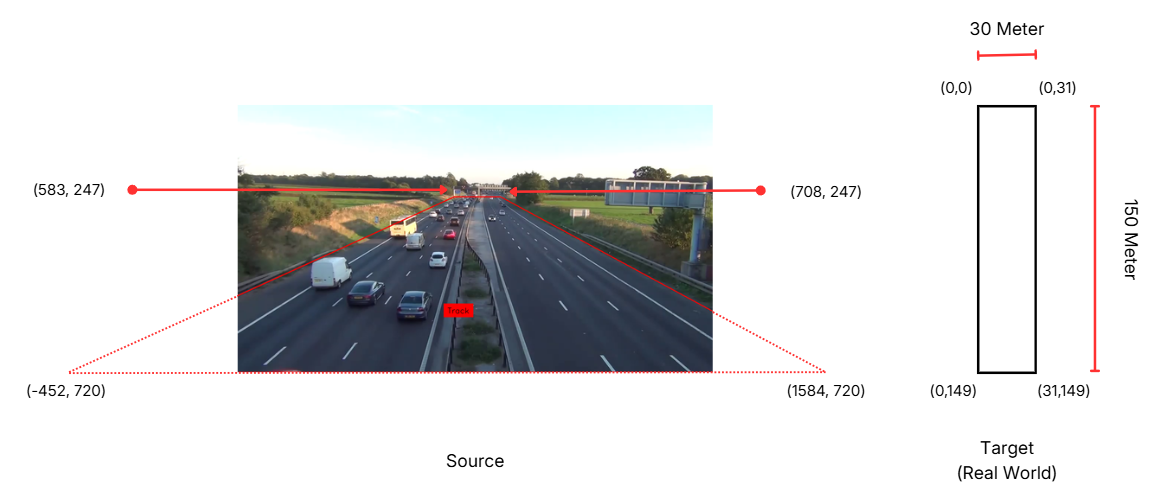

In [ ]:
# TRACK AREA (PIXEL SPACE)
track_points = np.array([
    [583, 247],
    [-452, 720],
    [1584, 720],
    [708, 247],
], dtype="float32")

# REAL-WORLD REFERENCE (METER)
dst_points = np.array([
    [0, 0],
    [0, 149],
    [31, 149],
    [31, 0],
], dtype="float32")

In [ ]:
# FRAME PREP
annotate = first_frame.copy()

# TRACK VISUALIZATION
track = sv.PolygonZone(
    polygon=track_points,
)
track_annotator = sv.PolygonZoneAnnotator(
    zone=track,
    color=sv.Color.RED,
    thickness=2,
    text_thickness=1,
    text_scale=0.7,
    opacity=0
)

annotate = track_annotator.annotate(scene=annotate, label="Track")
cv2_imshow(annotate)


Memvalidasi transformasi perspektif dengan memproyeksikan area lintasan ke tampilan top-down (bird’s-eye view).

In [ ]:
# FRAME PREP
annotate = first_frame.copy()

# WORLD SCALE (FOR VISUALIZATION)
WORLD_SCALE = 5

WORLD_W = int(30 * WORLD_SCALE)
WORLD_H = int(150 * WORLD_SCALE)

dst_points_px = dst_points * WORLD_SCALE

# HOMOGRAPHY (PIXEL → WORLD)
H, status = cv2.findHomography(
    track_points,
    dst_points_px
)

# BIRD'S-EYE VIEW
bev = cv2.warpPerspective(
    annotate,
    H,
    (WORLD_W, WORLD_H)
)

cv2_imshow(bev)


### Counting Speed Estimation

Menghitung kecepatan objek berdasarkan perpindahan posisi dunia nyata dalam rentang waktu tertentu sebagai validasi awal metode speed estimation.

In [ ]:
# STATE (TRACK HISTORY)
coordinates = defaultdict(lambda: deque(maxlen=int(fps)))

# TRACK ZONE
track_zone = sv.PolygonZone(polygon=track_points)

# HOMOGRAPHY (PIXEL → METER)
H_meter, _ = cv2.findHomography(track_points, dst_points)

def pixel_to_world(points_px, H):
    if len(points_px) == 0:
        return points_px
    pts = points_px.reshape(-1, 1, 2).astype(np.float32)
    world = cv2.perspectiveTransform(pts, H)
    return world.reshape(-1, 2)

# VIDEO + TRACKER
tracker = sv.ByteTrack()
cap = cv2.VideoCapture(raw_video_path)

width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps    = cap.get(cv2.CAP_PROP_FPS) or 25

# ANNOTATORS
box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

# LOOP (LIMITED FRAMES FOR VALIDATION)
idx = 0
while idx < 5:
    ret, frame = cap.read()
    if not ret:
        break

    # OBJECT DETECTION + TRACKING
    results = model.predict(
        frame,
        conf=0.25,
        classes=[2, 5, 7],
        verbose=False
    )
    detections = sv.Detections.from_ultralytics(results[0])
    detections = tracker.update_with_detections(detections)

    # ANCHOR POINT (BOTTOM CENTER)
    points_px = detections.get_anchors_coordinates(
        anchor=sv.Position.BOTTOM_CENTER
    )

    # FILTER BY TRACK ZONE
    in_zone_mask = track_zone.trigger(detections)
    detections = detections[in_zone_mask]
    points_px  = points_px[in_zone_mask]

    # WORLD COORDINATE
    points_world = pixel_to_world(points_px, H_meter)

    # UPDATE TRACK HISTORY
    for tid, p_world in zip(detections.tracker_id, points_world):
        coordinates[tid].append(p_world)

    # SPEED PER OBJECT (Δs / Δt)
    speed_map = {}
    for tid, history in coordinates.items():
        if len(history) >= 2:
            p_start = history[0]
            p_end   = history[-1]

            distance_m = np.linalg.norm(p_end - p_start)
            time_s = (len(history) - 1) / fps

            if time_s > 0:
                speed_map[tid] = (distance_m / time_s) * 3.6

    # AVG SPEED (PER FRAME)
    avg_speed = (
        sum(speed_map.values()) / len(speed_map)
        if speed_map else 0.0
    )

    # LABEL FORMAT (TRACK ID + SPEED)
    labels = []
    for class_name, conf, tid in zip(
        detections.data["class_name"],
        detections.confidence,
        detections.tracker_id
    ):
        label = f"#{tid} {class_name}"
        if tid in speed_map:
            label += f" {int(speed_map[tid])} km/h"
        labels.append(label)

    # VISUALIZATION
    annotated = box_annotator.annotate(frame, detections)
    annotated = label_annotator.annotate(
        annotated,
        detections,
        labels
    )

    draw_cell(
        annotated,
        10, 10, 200, 30,
        f"Avg Speed: {avg_speed:.1f} km/h",
        sv.Color.GREEN
    )

    cv2_imshow(annotated)
    idx += 1

# CLEANUP
cap.release()

## Pipeline

In [ ]:
# VIDEO & OUTPUT
cap = cv2.VideoCapture(raw_video_path)

width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps    = cap.get(cv2.CAP_PROP_FPS) or 25

ffmpeg = start_ffmpeg_writer(
    output_path="speed_estimation.mp4",
    width=width,
    height=height,
    fps=fps
)

# TRACKER & ANNOTATORS
tracker = sv.ByteTrack()

box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

# ZONES
in_zone = sv.PolygonZone(
    polygon=in_point,
    triggering_anchors=(sv.Position.BOTTOM_LEFT,)
)
out_zone = sv.PolygonZone(
    polygon=out_point,
    triggering_anchors=(sv.Position.TOP_RIGHT,)
)

in_zone_annotator = sv.PolygonZoneAnnotator(
    zone=in_zone, color=sv.Color.GREEN,
    thickness=2, text_scale=0.7, opacity=0.3
)
out_zone_annotator = sv.PolygonZoneAnnotator(
    zone=out_zone, color=sv.Color.RED,
    thickness=2, text_scale=0.7, opacity=0.3
)

# VEHICLE COUNTS
vehicle_counts = {
    "in":  {"all": set(), "car": set(), "bus": set(), "truck": set()},
    "out": {"all": set(), "car": set(), "bus": set(), "truck": set()}
}

# HOMOGRAPHY
track_points = np.array([
    [583, 247],
    [-452, 720],
    [1584, 720],
    [708, 247],
], dtype="float32")

dst_points = np.array([
    [0, 0],
    [0, 149],
    [31, 149],
    [31, 0],
], dtype="float32")

H_meter, _ = cv2.findHomography(track_points, dst_points)

def pixel_to_world(points_px, H):
    if len(points_px) == 0:
        return points_px
    pts = points_px.reshape(-1, 1, 2).astype(np.float32)
    world = cv2.perspectiveTransform(pts, H)
    return world.reshape(-1, 2)

# SPEED STATE
coordinates = defaultdict(lambda: deque(maxlen=int(fps)))
speed_ema = {}

WINDOW = int(fps * 0.5)
ALPHA = 0.2

# FINAL SPEED BUCKET
final_speed_in  = []
final_speed_out = []
last_zone_state = {}

# MAIN LOOP
while True:
    ret, frame = cap.read()
    if not ret:
        break

    # DETECTION + TRACKING
    results = model.predict(frame, conf=0.25, classes=[2,5,7], verbose=False)
    detections = sv.Detections.from_ultralytics(results[0])
    detections = tracker.update_with_detections(detections)

    # SPEED ESTIMATION
    points_px = detections.get_anchors_coordinates(
        anchor=sv.Position.BOTTOM_CENTER
    )
    points_world = pixel_to_world(points_px, H_meter)

    for tid, p_world in zip(detections.tracker_id, points_world):
        coordinates[tid].append(p_world)

    speed_map = {}
    for tid, history in coordinates.items():
        if len(history) < WINDOW:
            continue

        p_start = history[-WINDOW]
        p_end   = history[-1]

        distance_m = np.linalg.norm(p_end - p_start)
        if distance_m < 0.1:
            continue

        time_s = (WINDOW-1) / fps
        raw_speed = (distance_m / time_s) * 3.6

        if tid not in speed_ema:
            speed_ema[tid] = raw_speed
        else:
            speed_ema[tid] = (
                ALPHA * raw_speed +
                (1 - ALPHA) * speed_ema[tid]
            )

        speed_map[tid] = speed_ema[tid]

    # ZONE TRIGGER
    in_mask  = in_zone.trigger(detections)
    out_mask = out_zone.trigger(detections)

    ids_in  = set(detections.tracker_id[in_mask])
    ids_out = set(detections.tracker_id[out_mask])

    in_dets  = detections[in_mask]
    out_dets = detections[out_mask]

    # DATA SPEED (FINAL)
    for tid in detections.tracker_id:
        current_zone = None
        if tid in ids_in:
            current_zone = "IN"
        elif tid in ids_out:
            current_zone = "OUT"

        prev_zone = last_zone_state.get(tid)

        if prev_zone == "IN" and current_zone is None:
            if tid in speed_ema:
                final_speed_in.append(speed_ema[tid])

        if prev_zone == "OUT" and current_zone is None:
            if tid in speed_ema:
                final_speed_out.append(speed_ema[tid])

        last_zone_state[tid] = current_zone

    # AVG SPEED
    avg_speed_in = (
        sum(final_speed_in) / len(final_speed_in)
        if final_speed_in else 0
    )
    avg_speed_out = (
        sum(final_speed_out) / len(final_speed_out)
        if final_speed_out else 0
    )

    # LABELS
    labels = []
    for cls, conf, tid in zip(
        detections.data["class_name"],
        detections.confidence,
        detections.tracker_id
    ):
        label = f"#{tid} {cls}"
        if tid in speed_map:
            label += f" {int(speed_map[tid])} km/h"
        labels.append(label)

    # HISTORICAL PRESENCE COUNT
    collect_insight(vehicle_counts, in_dets, "in")
    collect_insight(vehicle_counts, out_dets, "out")

    # VISUALIZATION
    annotated = in_zone_annotator.annotate(frame, label="IN")
    annotated = out_zone_annotator.annotate(annotated, label="OUT")

    annotated = box_annotator.annotate(annotated, detections)
    annotated = label_annotator.annotate(annotated, detections, labels)

    draw_cell(
        annotated, 10, 10, 180, 30,
        f"Avg IN: {avg_speed_in:.1f} km/h", sv.Color.GREEN
    )
    draw_cell(
        annotated, width-190, 10, 180, 30,
        f"Avg OUT: {avg_speed_out:.1f} km/h", sv.Color.RED
    )

    annotated = draw_insight(annotated, vehicle_counts)

    ffmpeg.stdin.write(annotated.tobytes())

# CLEANUP
cap.release()
ffmpeg.stdin.close()
ffmpeg.wait()


Menampilkan video hasil dari proses speed estimation

In [ ]:
se_video_path = "speed_estimation.mp4"
display_mp4(video_path=se_video_path)

# Final Result

## Import Library

In [ ]:
from IPython.display import HTML, display
from base64 import b64encode
import os
import numpy as np
import cv2
import subprocess
import shlex
from collections import defaultdict, deque

import supervision as sv
from ultralytics import YOLO
from google.colab.patches import cv2_imshow

## Download Video Sources

In [ ]:
!gdown 1_9gMqPhNKOnbHUoSQvoWhvd8pUnxUOFB

## Utils

Kumpulan fungsi bantu yang digunakan untuk pemrosesan video, transformasi koordinat,
penghitungan historikal, dan visualisasi hasil.

In [ ]:
def display_mp4(
    video_path: str,
    width: int = 720,
    autoplay: bool = False,
    loop: bool = False,
    controls: bool = True,
):
    # INPUT VALIDATION
    if not os.path.exists(video_path):
        raise FileNotFoundError(f"Video not found: {video_path}")

    # LOAD VIDEO (BINARY)
    mp4 = open(video_path, "rb").read()

    # ENCODE → DATA URL
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()

    # HTML VIDEO EMBED
    html = f"""
    <video width="{width}"
           {'autoplay' if autoplay else ''}
           {'loop' if loop else ''}
           {'controls' if controls else ''}>
      <source src="{data_url}" type="video/mp4">
    </video>
    """

    # RENDER (NOTEBOOK)
    display(HTML(html))

In [ ]:
def start_ffmpeg_writer(
    output_path,
    width,
    height,
    fps=25
):
    # FFmpeg COMMAND
    cmd = f"""
    ffmpeg -y
    -f rawvideo
    -pix_fmt bgr24
    -s {width}x{height}
    -r {fps}
    -i -
    -an
    -c:v libx264
    -preset veryfast
    -pix_fmt yuv420p
    -movflags faststart
    {output_path}
    """

    # PROCESS PIPE (STDIN)
    return subprocess.Popen(
        shlex.split(cmd),
        stdin=subprocess.PIPE,
        stdout=subprocess.DEVNULL,
        stderr=subprocess.DEVNULL,
    )


In [ ]:
def collect_insight(vehicle_counts, detections, zone):
    # GUARD
    if detections.tracker_id is None:
        return

    # UPDATE COUNT STATE
    for class_name, tid in zip(
        detections.data["class_name"],
        detections.tracker_id
    ):
        vehicle_counts[zone]["all"].add(tid)
        vehicle_counts[zone][class_name].add(tid)

In [ ]:
def draw_cell(scene, x, y, width, height, text, color, opacity=0.5, text_scale: float = 0.5, text_thickness: int = 1):
    rect = sv.Rect(x, y, width, height)
    scene = sv.draw_filled_rectangle(
        scene=scene,
        rect=rect,
        color=color,
        opacity=opacity,
    )
    scene = sv.draw_text(
        scene=scene,
        text=text,
        text_anchor=sv.Point(
            x + width // 2,
            y + height // 2,
        ),
        text_color=sv.Color.WHITE,
        text_scale=text_scale,
        text_thickness=text_thickness,
    )

def draw_insight(
    scene: np.ndarray,
    vehicle_counts: dict,
    *,
    start_y: int = 10,
    gap_x: int = 10,
    gap_y: int = 6,
    width_in: int = 60,
    width_cat: int = 100,
    width_out: int = 60,
    height_row: int = 30,
    opacity: float = 0.5,
    text_scale: float = 0.5,
    text_thickness: int = 1,
) -> np.ndarray:

    h, w, _ = scene.shape

    # layout positions
    total_width = width_in + width_cat + width_out + gap_x * 2
    x_cat = w // 2 - width_cat // 2
    x_in = x_cat - width_in - gap_x
    x_out = x_cat + width_cat + gap_x

    # helper

    def get_count(direction, key):
        return len(vehicle_counts.get(direction, {}).get(key, set()))

    # header
    y = start_y

    draw_cell(scene, x_in, y, width_in, height_row, "IN", sv.Color.GREEN)
    draw_cell(scene, x_cat, y, width_cat, height_row, "CATEGORY", sv.Color.BLUE)
    draw_cell(scene, x_out, y, width_out, height_row, "OUT", sv.Color.RED)

    # rows (NO motorcycle)
    rows = ["all", "car", "bus", "truck"]

    for i, key in enumerate(rows, start=1):
        row_y = start_y + i * (height_row + gap_y)

        draw_cell(
            scene,
            x_in,
            row_y,
            width_in,
            height_row,
            f"{get_count('in', key):04d}",
            sv.Color.GREEN,
        )

        draw_cell(
            scene,
            x_cat,
            row_y,
            width_cat,
            height_row,
            key.upper(),
            sv.Color.BLUE,
        )

        draw_cell(
            scene,
            x_out,
            row_y,
            width_out,
            height_row,
            f"{get_count('out', key):04d}",
            sv.Color.RED,
        )

    return scene

In [ ]:
def pixel_to_world(points_px, H):
    if len(points_px) == 0:
        return points_px
    pts = points_px.reshape(-1, 1, 2).astype(np.float32)
    world = cv2.perspectiveTransform(pts, H)
    return world.reshape(-1, 2)

## Pipeline

In [ ]:
# VIDEO & OUTPUT
cap = cv2.VideoCapture(raw_video_path)

width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps    = cap.get(cv2.CAP_PROP_FPS) or 25

ffmpeg = start_ffmpeg_writer(
    output_path="speed_estimation.mp4",
    width=width,
    height=height,
    fps=fps
)

# TRACKER & ANNOTATORS
tracker = sv.ByteTrack()

box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

# ZONES
in_zone = sv.PolygonZone(
    polygon=in_point,
    triggering_anchors=(sv.Position.BOTTOM_LEFT,)
)
out_zone = sv.PolygonZone(
    polygon=out_point,
    triggering_anchors=(sv.Position.TOP_RIGHT,)
)

in_zone_annotator = sv.PolygonZoneAnnotator(
    zone=in_zone, color=sv.Color.GREEN,
    thickness=2, text_scale=0.7, opacity=0.3
)
out_zone_annotator = sv.PolygonZoneAnnotator(
    zone=out_zone, color=sv.Color.RED,
    thickness=2, text_scale=0.7, opacity=0.3
)

# VEHICLE COUNTS
vehicle_counts = {
    "in":  {"all": set(), "car": set(), "bus": set(), "truck": set()},
    "out": {"all": set(), "car": set(), "bus": set(), "truck": set()}
}

# HOMOGRAPHY
track_points = np.array([
    [583, 247],
    [-452, 720],
    [1584, 720],
    [708, 247],
], dtype="float32")

dst_points = np.array([
    [0, 0],
    [0, 149],
    [31, 149],
    [31, 0],
], dtype="float32")

H_meter, _ = cv2.findHomography(track_points, dst_points)

def pixel_to_world(points_px, H):
    if len(points_px) == 0:
        return points_px
    pts = points_px.reshape(-1, 1, 2).astype(np.float32)
    world = cv2.perspectiveTransform(pts, H)
    return world.reshape(-1, 2)

# SPEED STATE
coordinates = defaultdict(lambda: deque(maxlen=int(fps)))
speed_ema = {}

WINDOW = int(fps * 0.5)
ALPHA = 0.2

# FINAL SPEED BUCKET
final_speed_in  = []
final_speed_out = []
last_zone_state = {}

# MAIN LOOP
while True:
    ret, frame = cap.read()
    if not ret:
        break

    # DETECTION + TRACKING
    results = model.predict(frame, conf=0.25, classes=[2,5,7], verbose=False)
    detections = sv.Detections.from_ultralytics(results[0])
    detections = tracker.update_with_detections(detections)

    # SPEED ESTIMATION
    points_px = detections.get_anchors_coordinates(
        anchor=sv.Position.BOTTOM_CENTER
    )
    points_world = pixel_to_world(points_px, H_meter)

    for tid, p_world in zip(detections.tracker_id, points_world):
        coordinates[tid].append(p_world)

    speed_map = {}
    for tid, history in coordinates.items():
        if len(history) < WINDOW:
            continue

        p_start = history[-WINDOW]
        p_end   = history[-1]

        distance_m = np.linalg.norm(p_end - p_start)
        if distance_m < 0.1:
            continue

        time_s = (WINDOW-1) / fps
        raw_speed = (distance_m / time_s) * 3.6

        if tid not in speed_ema:
            speed_ema[tid] = raw_speed
        else:
            speed_ema[tid] = (
                ALPHA * raw_speed +
                (1 - ALPHA) * speed_ema[tid]
            )

        speed_map[tid] = speed_ema[tid]

    # ZONE TRIGGER
    in_mask  = in_zone.trigger(detections)
    out_mask = out_zone.trigger(detections)

    ids_in  = set(detections.tracker_id[in_mask])
    ids_out = set(detections.tracker_id[out_mask])

    in_dets  = detections[in_mask]
    out_dets = detections[out_mask]

    # DATA SPEED (FINAL)
    for tid in detections.tracker_id:
        current_zone = None
        if tid in ids_in:
            current_zone = "IN"
        elif tid in ids_out:
            current_zone = "OUT"

        prev_zone = last_zone_state.get(tid)

        if prev_zone == "IN" and current_zone is None:
            if tid in speed_ema:
                final_speed_in.append(speed_ema[tid])

        if prev_zone == "OUT" and current_zone is None:
            if tid in speed_ema:
                final_speed_out.append(speed_ema[tid])

        last_zone_state[tid] = current_zone

    # AVG SPEED
    avg_speed_in = (
        sum(final_speed_in) / len(final_speed_in)
        if final_speed_in else 0
    )
    avg_speed_out = (
        sum(final_speed_out) / len(final_speed_out)
        if final_speed_out else 0
    )

    # LABELS
    labels = []
    for cls, conf, tid in zip(
        detections.data["class_name"],
        detections.confidence,
        detections.tracker_id
    ):
        label = f"#{tid} {cls}"
        if tid in speed_map:
            label += f" {int(speed_map[tid])} km/h"
        labels.append(label)

    # HISTORICAL PRESENCE COUNT
    collect_insight(vehicle_counts, in_dets, "in")
    collect_insight(vehicle_counts, out_dets, "out")

    # VISUALIZATION
    annotated = in_zone_annotator.annotate(frame, label="IN")
    annotated = out_zone_annotator.annotate(annotated, label="OUT")

    annotated = box_annotator.annotate(annotated, detections)
    annotated = label_annotator.annotate(annotated, detections, labels)

    draw_cell(
        annotated, 10, 10, 180, 30,
        f"Avg IN: {avg_speed_in:.1f} km/h", sv.Color.GREEN
    )
    draw_cell(
        annotated, width-190, 10, 180, 30,
        f"Avg OUT: {avg_speed_out:.1f} km/h", sv.Color.RED
    )

    annotated = draw_insight(annotated, vehicle_counts)

    ffmpeg.stdin.write(annotated.tobytes())

# CLEANUP
cap.release()
ffmpeg.stdin.close()
ffmpeg.wait()